# 提取数据
第一列是评分1～5\
第二列是评论标题\
第三列是评论正文

In [8]:
import pandas as pd
from collections import Counter
from tqdm import tqdm
test = pd.read_csv('test.csv',header=None)
test.head()

,0,1,2
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,2,Oh dear,I was excited to find a book ostensibly about ...
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."


In [9]:
train = pd.read_csv('train.csv',header=None)
train.head()

,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


## 查看数据

In [10]:
import numpy as np
test_data=test[2]
test_label=test[0]
print('size of test data is ',len(test_data))
print('the score of: "',test_data[1],'"is ',test_label[1])

size of test data is  650000
the score of: " This is a fast read filled with unexpected humour and profound insights into the art of politics and policy. In brief, it is sly, wry, and wise. "is  4


In [11]:
train_data=train[2]
train_label=train[0]
print('size of train data is ',len(train_data))
print('the score of: "',train_data.iloc[0],'"is ',train_label.iloc[0])

size of train data is  3000000
the score of: " Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it! "is  3


# Naive Bayes

## 清洗数据
只保留单词；将字母处理为小写；删掉停用词；

In [12]:
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
def cleanText(raw_text,remove_stopwords=True,sentences=False):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)
    text=letters_only.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    if sentences:
        return " ".join(text)
    else:
        return text
text=cleanText(train_data.iloc[0],sentences=True)
print("Before processing: ",train_data.iloc[0])
print("After processing: ",text)

Before processing:  Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it!
After processing:  gave dad gag gift directing nunsense got reall kick


## 重采样取部分数据实验

In [86]:
import numpy as np
t_data,t_label=[],[]
for i in range(50000):
    idx=np.random.randint(len(train_data))
    t_data.append(train_data[idx])
    t_label.append(train_label[idx])

test,label=[],[]
for i in range(2000):
    idx=np.random.randint(len(test_data))
    test.append(test_data[idx])
    label.append(test_label[idx])

len(t_label)

50000

In [87]:
train_clean,test_clean=[],[]
for i in tqdm(range(len(t_data))):
    train_clean.append(cleanText(t_data[i],remove_stopwords=True,sentences=True))
for i in tqdm(range(len(test))):
    test_clean.append(cleanText(test[i],remove_stopwords=True,sentences=True))

100%|██████████| 2000/2000 [00:00<00:00, 5868.32it/s]


In [88]:
# import pickle
# with open('cleanedData.pickle','wb') as f:
#     pickle.dump(train_clean,f)
#     pickle.dump(test_clean,f)

In [89]:
# with open('cleanedData.pickle','rb') as f:
#     train_clean=pickle.load(f)
#     test_clean=pickle.load(f)

In [90]:
print(train_clean[0])
print(train_label[0])

primarily enjoy war movies provide factual recounts events persons covered film war movies sake war movie movie battle bulge provide much anything historic uses historic event tell hollywood istic story great actors film though simple opinon provide redeeming value film like action wwii war movies probably enjoy excpect semblance history film likely impress much sure would nice hollywood battle bulge tora tora tora fashion basis judging war movies
3


## 使用sklearn的CountVectorizer得到语料库

也可以自己生成语料库，比如在train text中出现cutoff次以上的词语放入语料库

## 出现次数在5次以上的词汇加入语料库

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
countVect = CountVectorizer(min_df=5) 
train_vec = countVect.fit_transform(train_clean)

In [92]:
print("Number of features : %d \n" %len(countVect.get_feature_names())) 
corpus=list(countVect.get_feature_names())
print("part of words in Corpus: ",corpus[:10])

Number of features : 19239 

part of words in Corpus:  ['aa', 'aaa', 'aaliyah', 'aaron', 'ab', 'abandon', 'abandoned', 'abandoning', 'abba', 'abbey']


## 计算某review里的词汇在词汇表中出现的次数

### 如果在文档中出现但没有在词汇表中出现用none代替

In [93]:
def create_bow(corpus, review):
    """
    return: {'a': 2, None: 3, '.': 1}
    """
    word=Counter(review.split())
    res={}
    for w in word:
        if w in corpus:
            res[w]=word[w]
        else:
            if not 'None' in res:
                res['None']=word[w]
            else:
                res['None']+=word[w]
    return res

In [94]:
print(create_bow(corpus, train_clean[0]))

{'primarily': 1, 'enjoy': 2, 'war': 5, 'movies': 4, 'provide': 3, 'factual': 1, 'recounts': 1, 'events': 1, 'persons': 1, 'covered': 1, 'film': 4, 'sake': 1, 'movie': 2, 'battle': 2, 'bulge': 2, 'much': 2, 'anything': 1, 'historic': 2, 'uses': 1, 'event': 1, 'tell': 1, 'hollywood': 2, 'None': 2, 'story': 1, 'great': 1, 'actors': 1, 'though': 1, 'simple': 1, 'opinon': 1, 'redeeming': 1, 'value': 1, 'like': 1, 'action': 1, 'wwii': 1, 'probably': 1, 'semblance': 1, 'history': 1, 'likely': 1, 'impress': 1, 'sure': 1, 'would': 1, 'nice': 1, 'tora': 3, 'fashion': 1, 'basis': 1, 'judging': 1}


## 整合所有训练数据的词袋

In [95]:

def load_training_data(corpus, train_clean, train_label):
    """
    return:
    [{'label': 1, 'bow': {'it': 1, 'is': 1, 'february': 1, '19': 1, ',': 1, '2020': 1, '.': 1}},
    {'label':  2, 'bow': {'hello': 1, 'world': 1, 'None':2 }},
    {'label':  3, 'bow': {'a': 2, 'dog': 1, 'chases': 1, 'cat': 1, '.': 1}}]
    """
    res=[]
    for i in tqdm(range(len(train_clean))):
        bow=create_bow(corpus, train_clean[i])
        temp={'label':train_label[i],'bow':bow}
        res.append(temp)
    return res

## 查看部分词袋数据

In [96]:
bow=load_training_data(corpus, train_clean, t_label)
bow[0]

100%|██████████| 50000/50000 [04:35<00:00, 181.58it/s]


{'label': 2,
 'bow': {'primarily': 1,
  'enjoy': 2,
  'war': 5,
  'movies': 4,
  'provide': 3,
  'factual': 1,
  'recounts': 1,
  'events': 1,
  'persons': 1,
  'covered': 1,
  'film': 4,
  'sake': 1,
  'movie': 2,
  'battle': 2,
  'bulge': 2,
  'much': 2,
  'anything': 1,
  'historic': 2,
  'uses': 1,
  'event': 1,
  'tell': 1,
  'hollywood': 2,
  'None': 2,
  'story': 1,
  'great': 1,
  'actors': 1,
  'though': 1,
  'simple': 1,
  'opinon': 1,
  'redeeming': 1,
  'value': 1,
  'like': 1,
  'action': 1,
  'wwii': 1,
  'probably': 1,
  'semblance': 1,
  'history': 1,
  'likely': 1,
  'impress': 1,
  'sure': 1,
  'would': 1,
  'nice': 1,
  'tora': 3,
  'fashion': 1,
  'basis': 1,
  'judging': 1}}

## 先验概率

In [97]:
def prior(train_label):
    # 各评分的先验概率
    record=Counter(list(train_label))
    print(record)
    P={}
    for s in record:
        P[s]= np.log((record[s]+1)/(len(train_label)+5))
    return P

In [98]:
P=prior(t_label)
P

Counter({3: 10056, 4: 10026, 2: 10016, 5: 10008, 1: 9894})


{2: -1.6078393507988522,
 3: -1.603854090966136,
 4: -1.6068415458866911,
 1: -1.6200934213739504,
 5: -1.6086383121915975}

## 计算每个label里的词汇在词汇表中出现的次数
如果在文档中出现但没有在词汇表中出现用none代替

In [99]:
def p_word_given_label(corpus,bow,score):
    # 每个分组下每个单词出现的概率 P(word_i|y=y_k)
    # 各个分组下词汇总数
    res={}
    corpus_copy=corpus[:]
    corpus_copy.append('None')
    
    num_label=0
    for sample in bow:
        if sample['label']==score:
            num_label+=1
    
    for word in corpus_copy:
        num_word_label=0
        for sample in bow:
            if sample['label']==score and word in sample['bow']:
                num_word_label+=sample['bow'][word]
        res[word]=np.log((num_word_label+1)/(num_label+len(corpus)))
    return res

### 测试一个正面单词，评分高的评论中出现频率更高

In [100]:
p_word_label1=p_word_given_label(corpus,bow,1)
p_word_label5=p_word_given_label(corpus,bow,5)
print(p_word_label1['perfect'])
print(p_word_label5['perfect'])

-5.625666481104941
-4.109746179395445


In [101]:
wordBag={}
for i in tqdm(range(1,6)):
    wordBag[i]=p_word_given_label(corpus,bow,i)

100%|██████████| 5/5 [20:10<00:00, 242.16s/it]


## 整合模型

In [102]:
def NBtraining(corpus,P,wordBag):
    """
     {'vocabulary': ['.', 'a'],\
     'log prior': {1: -0.916290731874155, 2: -0.5108256237659905,....},\
     'log p(w|y=1)': {'.': -1.6094379124341005, 'a': -2.302585092994046, None: -0.35667494393873267},\
     'log p(w|y=2)': {'.': -1.7047480922384253, 'a': -1.2992829841302609, None: -0.6061358035703157},\
     ......}
    """
    res={}
    res['vocabulary']=corpus
    res['log prior']=P
    res[1]=wordBag[1]
    res[2]=wordBag[2]
    res[3]=wordBag[3]
    res[4]=wordBag[4]
    res[5]=wordBag[5]
    return res

In [103]:
model=NBtraining(corpus,P,wordBag)

In [109]:
import pickle
with open('model50k.pickle','wb') as f:
    pickle.dump(model,f)

## 后验概率

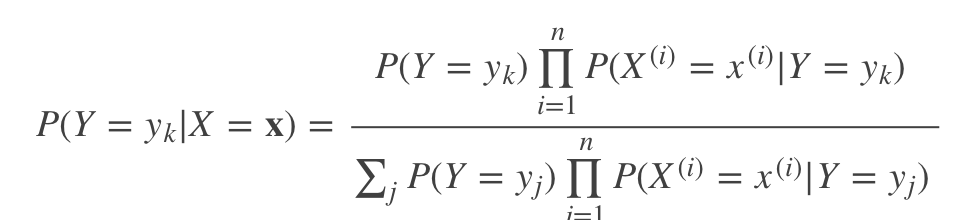

In [104]:
def NBclassifiar(test_clean,model):
    pred=[]
    for text in tqdm(test_clean):
        text_bow=create_bow(corpus,text)
        p={}
        for score in range(1,6):
            p[score]=0
        for word in text_bow:
            for score in range(1,6):
                if word in model[score]:
                    p[score]+=model[score][word]*text_bow[word]
        for score in range(1,6):
            p[score]+=model['log prior'][score]
        pred.append(max(p,key=p.get))
    return pred

In [115]:
pred=NBclassifiar(test,model)

100%|██████████| 2000/2000 [00:28<00:00, 71.32it/s]


In [118]:
testId=3
print('预测评分: ',pred[testId])
print('实际评分: ',label[testId])
print(test[testId])

预测评分:  3
实际评分:  3
This hoster when first opening it seemed a little tight but after playing with it seemed to loosen up a bit. I was afraid of damaging my light because of tightness but it seems to be easier everytime you use it.


In [128]:
def NBaccuracy(pred,label):
    right=0
    for p,a in zip(pred,label):
        if p>=4 and a>=4:
            right+=1
        elif p<4 and a<4:
            right+=1
    return 100*right/len(label)

In [129]:
accuracy=NBaccuracy(pred,label)
print('accuracy= ',accuracy,'%')

accuracy=  68.9 %


## 单句测试

In [131]:
t=['ok...it doesn''t work, to be honest, it''s a piece of junk, I won''t buy it again. ']
p=NBclassifiar(t,model)
p

100%|██████████| 1/1 [00:00<00:00, 110.69it/s]


[1]

## 使用sklearn验证

In [132]:
# Preprocess text data in training set and validation set
X_train_cleaned = train_clean
X_test_cleaned = test_clean

In [134]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) 
print("Show some feature names : \n", countVect.get_feature_names()[-120:-100])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, t_label)

Number of features : 75127 

Show some feature names : 
 ['zion', 'zionism', 'zionist', 'zionists', 'zip', 'ziploc', 'ziplock', 'zipped', 'zipper', 'zippered', 'zipperhead', 'zippers', 'zipping', 'zippo', 'zipporah', 'zippper', 'zips', 'ziq', 'zirconia', 'zit']


MultinomialNB()

In [135]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(label, predictions)))

In [136]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
right=0
for i,j in zip(predictions,label):
    if i>=4 and j>=4 or i<4 and j<4:
        right+=1
accuracy=100*right/len(label)
print('accuracy= ',accuracy,'%')     

accuracy=  74.35 %
